In [1]:
import numpy as np
import scipy.interpolate as spi
from scipy.stats import norm
from scipy.interpolate import CubicSpline
from scipy.interpolate import Akima1DInterpolator
from analysis.TabPFN import compute_cdf_pdf_interpolators
from analysis.TabPFN import plot_cdf_pdf_dynamic
from analysis.TabPFN import evaluate


Probabilities: [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]
Quantiles: [-1.28155157 -0.84162123 -0.52440051 -0.2533471   0.          0.2533471
  0.52440051  0.84162123  1.28155157]
Estimated Mean: -3.0819390988122016e-33, Estimated Std Dev: 1.0


<Figure size 1100x600 with 0 Axes>

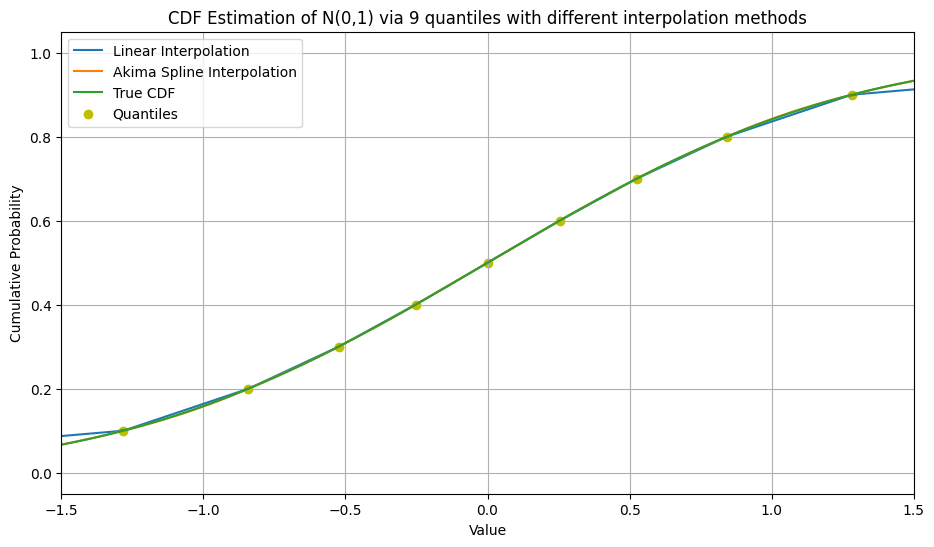

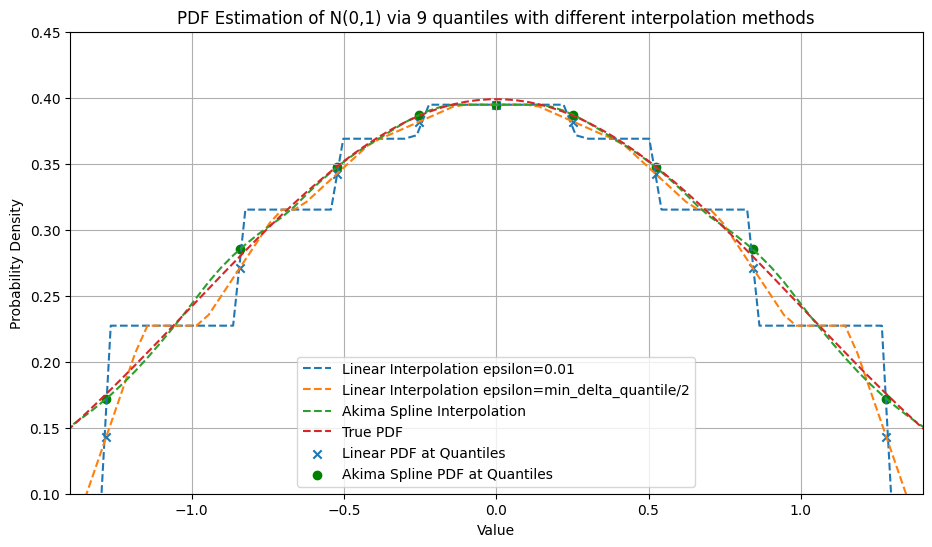

Probabilities: [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]
Quantiles: [-1.28155157 -0.84162123 -0.52440051 -0.2533471   0.          0.2533471
  0.52440051  0.84162123  1.28155157]
Estimated Mean: -3.0819390988122016e-33, Estimated Std Dev: 1.0


<Figure size 1100x600 with 0 Axes>

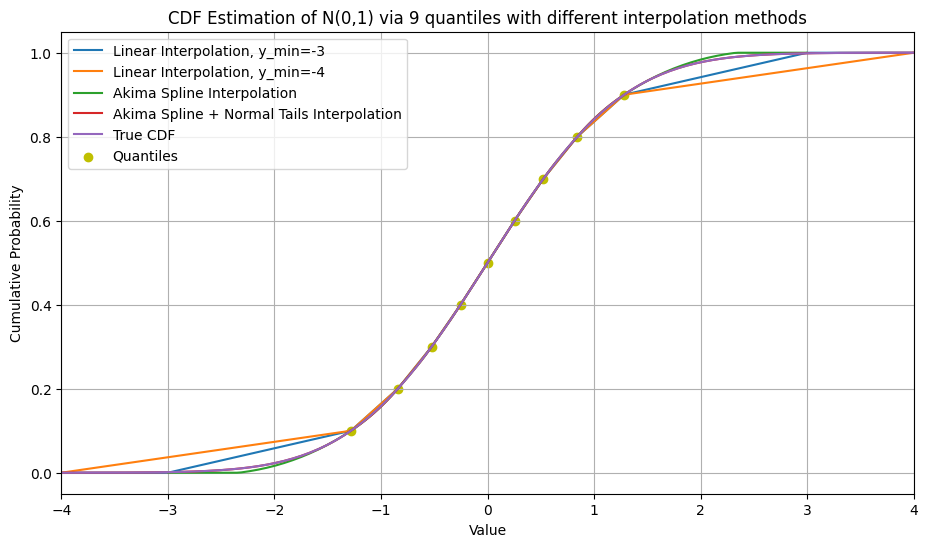

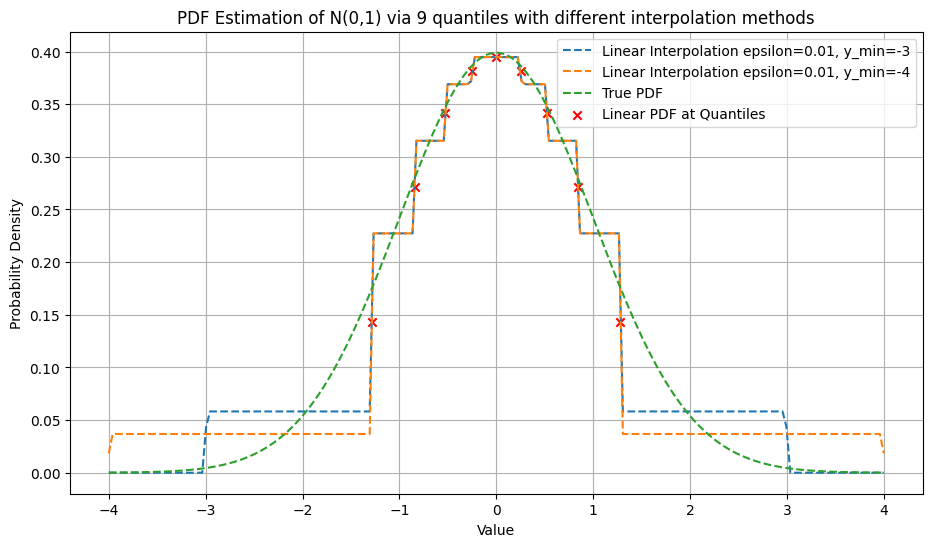

Probabilities: [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]
Quantiles: [-1.28155157 -0.84162123 -0.52440051 -0.2533471   0.          0.2533471
  0.52440051  0.84162123  1.28155157]
Estimated Mean: -3.0819390988122016e-33, Estimated Std Dev: 1.0


<Figure size 1100x600 with 0 Axes>

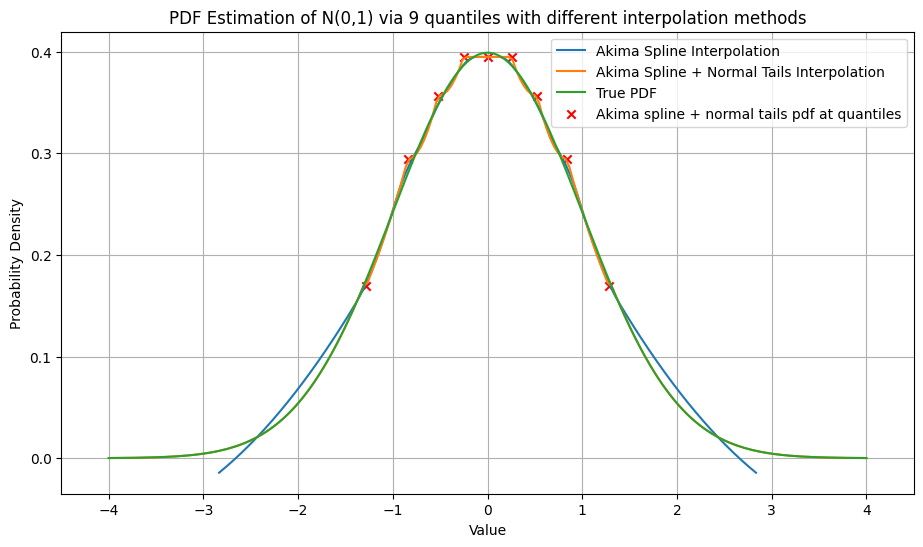

In [5]:
probabilities = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
quantiles = norm.ppf(probabilities)
y_min = -3
y_max = 3

plot_cdf_pdf_dynamic(quantiles, probabilities, y_min, y_max, log_scale=False, case=1)
plot_cdf_pdf_dynamic(quantiles, probabilities, y_min, y_max, log_scale=False, case=2)
plot_cdf_pdf_dynamic(quantiles, probabilities, y_min, y_max, log_scale=False, case=3)

In [7]:
probabilities = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
quantiles = norm.ppf(probabilities)
y_min = -3
y_max = 3

evaluate(quantiles, probabilities, -2.5, y_min, y_max)

(('crps_cdf_linear', 1.8764192382545373),
 ('crps_cdf_pchip', 1.9508986356133764),
 ('crps_hybrid_cdf', 1.9401850423853335),
 ('nll_pdf_linear (eps = 0.01)', 2.8440069037156945),
 ('nll_pdf_linear2 (eps = min_delta_quantile/2)', 2.8440069037156697),
 ('nll_pdf_pchip', 4.252659642360903),
 ('nll_pdf_hybrid', 4.043938533204672))

## Test with quantiles given back by TabPFN

In [12]:
probabilities = np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
quantiles_2 = np.array([-3.302027, -2.657532, -2.326192, -2.163070, -1.983908, -1.761671, -1.496187, -1.286693, -1.028827])
quantiles_3 = np.array([-3.295995, -2.666942, -2.325560, -2.164748, -1.986944, -1.763564, -1.498355, -1.278293, -1.031841])
quantiles_4 = np.array([-3.289948, -2.672929, -2.321413, -2.163413, -1.990395, -1.773206, -1.510069, -1.285333, -1.042485])
y_min = -5
y_max = 5

evaluate(quantiles_4, probabilities, -1, y_min, y_max)

C:\Users\Manuel\Documents\Masterarbeit\src\analysis\TabPFN.py:303: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  crps_value, _ = quad(integrand, y_min, y_max)


(('crps_cdf_linear', 0.6307217163571393),
 ('crps_cdf_pchip', 0.6085116393500668),
 ('crps_hybrid_cdf', 0.6087589781647472),
 ('nll_pdf_linear (eps = 0.01)', 4.101400444170063),
 ('nll_pdf_linear2 (eps = min_delta_quantile/2)', 2.226640262555347),
 ('nll_pdf_pchip', 0.983166205522976),
 ('nll_pdf_hybrid', 1.2475395254789359))

# Cross check the crps and nll calculation based on a known distribution (normal)

In [13]:
import pandas as pd
mu = 2
sigma = 1.5
y_min = mu - 7*sigma
y_max = mu + 7*sigma
probabilities = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
quantiles = norm.ppf(probabilities, loc=mu, scale=sigma)

y_values = [-4, -2, 0, 2, 4]

results_list = []

for y in y_values:
    z = (y - mu) / sigma
    crps_true = sigma * (z * (2 * norm.cdf(z) - 1) + 2 * norm.pdf(z) - 1 / np.sqrt(np.pi))
    nll_true = -norm.logpdf(y, scale=sigma, loc=mu)

    evaluate_results = evaluate(quantiles, probabilities, y, y_min, y_max)
    evaluate_dict = dict(evaluate_results)

    results_list.append({
        "y": y,
        "CRPS (Analytical)": crps_true,
        "CRPS (CDF Linear)": evaluate_dict["crps_cdf_linear"],
        "CRPS (CDF PCHIP, cubic interpolation)": evaluate_dict["crps_cdf_pchip"],
        "CRPS (Hybrid CDF)": evaluate_dict["crps_hybrid_cdf"],
        "NLL (Analytical)": nll_true,
        "NLL (PDF Linear, eps = 0.01)": evaluate_dict["nll_pdf_linear (eps = 0.01)"],
        "NLL (PDF Linear2, eps = min_delta_quantile/2)": evaluate_dict["nll_pdf_linear2 (eps = min_delta_quantile/2)"],
        "NLL (PDF PCHIP)": evaluate_dict["nll_pdf_pchip"],
        "NLL (PDF Hybrid)": evaluate_dict["nll_pdf_hybrid"]
    })

results = pd.DataFrame(results_list)

results.to_excel("../results/TabPFN/true_crps_nll_vs_interpolated.xlsx", index=False)



# Check with PchipInterpolator instead of Akima1DInterpolator

Probabilities: [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]
Quantiles: [-1.28155157 -0.84162123 -0.52440051 -0.2533471   0.          0.2533471
  0.52440051  0.84162123  1.28155157]
Estimated Mean: 3.0814879110195774e-33, Estimated Std Dev: 1.0
epsilon 0.12667355156789986
Step cdf_chip 0.03349097160643472 0.0569872753350617
epsilon 0.12667355156789986
Step cdf_chip 0.03037044298855726 0.05280911150029423
epsilon 0.12667355156789986
Step cdf_chip 0.027412221771850553 0.04880277915304641
epsilon 0.12667355156789986
Step cdf_chip 0.024614796678551987 0.044966767015555686
epsilon 0.12667355156789986
Step cdf_chip 0.021976656430899084 0.0412995638100596
epsilon 0.12667355156789986
Step cdf_chip 0.019496289751129256 0.037799658258795464
epsilon 0.12667355156789986
Step cdf_chip 0.017172185361479988 0.0344655390840008
epsilon 0.12667355156789986
Step cdf_chip 0.015002831984188765 0.03129569500791312
epsilon 0.12667355156789986
Step cdf_chip 0.012986718341493002 0.02828861475276982
epsilon 0.126673551

<Figure size 1100x600 with 0 Axes>

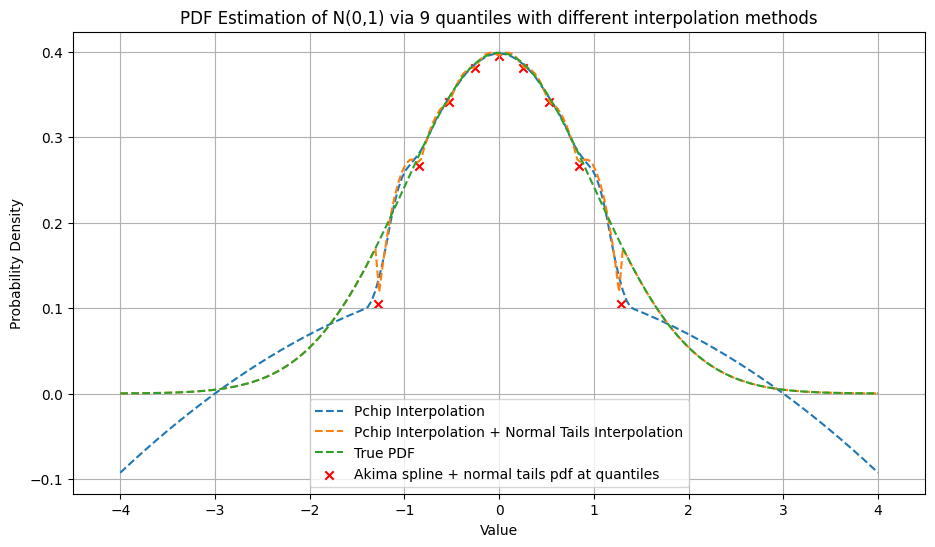

In [2]:
probabilities = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
quantiles = norm.ppf(probabilities)
y_min = -3
y_max = 3

plot_cdf_pdf_dynamic(quantiles, probabilities, y_min, y_max, log_scale=False, case=3)